<a href="https://colab.research.google.com/github/Felpezs/Sentiment-Analysis/blob/master/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ACML IMDB



##Organização



O dataset está dividido da seguinte forma:

- Train/Test
  - Positive/Negative Reviews, BOW e Urls das reviews (somente o id da obra funciona)
    - Reviews

### Sobre dados de teste e treino

O dataset possui 25 mil dados para treino e 25 mil dados para teste. A proporção de sentimentos positivos e negativos também está igualmente distribuida.

### Reviews

As reviews estão divididas nas pastas pos (sentimento positivo) e neg (sentimento negativo). Os reviews negativos possuem notas <=4, enquanto os positivos possuem notas >=5, reviews mais neutras, portanto, foram desconsideradas.

### Nomes dos arquivos

As reviews são organizadas da seguinte forma: [ [ **id** ]_[ **rating** ] ].txt. Sendo assim, o arquivo 0_9.txt, na pasta [train/pos], indica uma review de treino positivo, com id 0 e com rating 9

<br>

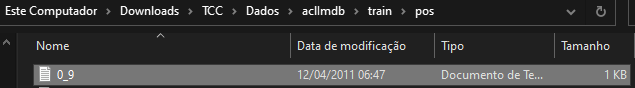

### Bag of Words

Estão armazenados em arquivos [.feat], no formato LIBSVM (formato de vetor esparso ascii para dados routulados).
Os indíces das features nesses arquivos iniciam em 0, e o token dos textos correspondem a um index de feature encontrado em [imdb.vocab]. Então uma linha com 0:7 em um arquivo .feat significa que a primeira palavra em [imdb.vocab] (the) aparece 7 vezes naquela review.

# Trabalhando com o dataset


In [ ]:
!pip install nltk

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
from nltk.stem import WordNetLemmatizer as wnl
from nltk.tokenize import word_tokenize, WordPunctTokenizer, WhitespaceTokenizer
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import pickle

nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [ ]:
df_train = pd.read_csv('aclImdb_train.csv')
df_train = df_train.sample(frac=1, random_state=2023)
df_train.head(10)

##Tratando os dados


### Pré processamento

In [ ]:
# Remocao de valores duplicados

print(f"Soma de reviews duplicados: {df_train.duplicated(subset=['text']).sum()}")
text = df_train['text']
duplicated = df_train[text.isin(text[text.duplicated()])].sort_values('text')
duplicated.head(10)

Soma de reviews duplicados: 96


,reviewIndex,text,sentiment
18447,4102,'Dead Letter Office' is a low-budget film abou...,negative
24842,985,'Dead Letter Office' is a low-budget film abou...,negative
8131,6069,".......Playing Kaddiddlehopper, Col San Fernan...",positive
11742,9319,".......Playing Kaddiddlehopper, Col San Fernan...",positive
21983,7286,"<br /><br />Back in his youth, the old man had...",negative
21984,7287,"<br /><br />Back in his youth, the old man had...",negative
8576,646,A have a female friend who is currently being ...,positive
8554,644,A have a female friend who is currently being ...,positive
5070,3313,"A longtime fan of Bette Midler, I must say her...",positive
12123,9662,"A longtime fan of Bette Midler, I must say her...",positive


In [ ]:
# Verificando tags

texts_tags = df_train['text'].apply(lambda text : len(re.findall('<.*?>', text)))
print(f'Quantidade de tags nos textos: {texts_tags.sum()}')

Quantidade de tags nos textos: 101630


In [ ]:
# Verificando URLS

texts_urls = df_train['text'].apply(lambda text : len(re.findall('https?://\S+|www\.\S+', text)))
print(f'Quantidade de URLS nos textos: {texts_urls.sum()}')

Quantidade de URLS nos textos: 67


In [ ]:
#Gerando tokens

text = 'This film is great (it isn\'t). But the plot twist is mind-blowing :-)'

tokens = text.split()
tokens2 = word_tokenize(text)
tokens3 = WordPunctTokenizer().tokenize(text)
tokens4 = WhitespaceTokenizer().tokenize(text)

print("TOKENIZAÇÃO: ")
print(f'Com split: {tokens}')
print(f'Com wordTokenize: {tokens2}')
print(f'Com wordPunctTokenizer: {tokens3}')
print(f'Com whiteSpaceTokenizer: {tokens4}')

TOKENIZAÇÃO: 
Com split: ['This', 'film', 'is', 'great', '(it', "isn't).", 'But', 'the', 'plot', 'twist', 'is', 'mind-blowing', ':-)']
Com wordTokenize: ['This', 'film', 'is', 'great', '(', 'it', 'is', "n't", ')', '.', 'But', 'the', 'plot', 'twist', 'is', 'mind-blowing', ':', '-', ')']
Com wordPunctTokenizer: ['This', 'film', 'is', 'great', '(', 'it', 'isn', "'", 't', ').', 'But', 'the', 'plot', 'twist', 'is', 'mind', '-', 'blowing', ':-)']
Com whiteSpaceTokenizer: ['This', 'film', 'is', 'great', '(it', "isn't).", 'But', 'the', 'plot', 'twist', 'is', 'mind-blowing', ':-)']


In [ ]:
#Funcoes usadas em um pipeline para o pre processamento

def remove_tags(text):
    pattern = '<.*?>'
    return re.sub(pattern, ' ', text)

def remove_urls(text):
  pattern = "https?://\S+|www\.\S+"
  return re.sub(pattern, '', text)

def remove_special_chars(text):
  pattern = '[\.\,]'
  return re.sub(pattern, '', text)

def getWordnetTag(treeBankTag):
  #Converte uma tag do treebank (https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html) para tags reconhecidas pelo wordnet
  if treeBankTag.startswith('J'):
    return wn.ADJ
  elif treeBankTag.startswith('V'):
    return wn.VERB
  elif treeBankTag.startswith('R'):
    return wn.ADV
  return wn.NOUN

def generate_lemma(text):
  #O uso do wordPunctTokenizer foi feito para manter principalmente os emoticons, já que eles por si só são indicativos de sentimentos
  tokens = WordPunctTokenizer().tokenize(text)
  tokens = nltk.pos_tag(tokens)
  return ' '.join([wnl().lemmatize(token[0], pos=getWordnetTag(token[1])) for token in tokens])

def clean_text(text):
  text = text.lower()
  text = remove_tags(text)
  text = remove_urls(text)
  text = remove_special_chars(text)
  return generate_lemma(text)

print(f"Pré limpeza dos dados:")
df_train['text'][1]

Pré limpeza dos dados:


'homelessness (or houselessness as george carlin stated) has been an issue for years but never a plan to help those on the street that were once considered human who did everything from going to school work or vote for the matter most people think of the homeless as just a lost cause while worrying about things such as racism the war on iraq pressuring kids to succeed technology the elections inflation or worrying if they\'ll be next to end up on the streets  but what if you were given a bet to live on the streets for a month without the luxuries you once had from a home the entertainment sets a bathroom pictures on the wall a computer and everything you once treasure to see what it\'s like to be homeless? that is goddard bolt\'s lesson  mel brooks (who directs) who stars as bolt plays a rich man who has everything in the world until deciding to make a bet with a sissy rival (jeffery tambor) to see if he can live in the streets for thirty days without the luxuries; if bolt succeeds he 

In [ ]:
df_train.drop_duplicates(subset=['text'], inplace = True)
df_train['text'] = df_train['text'].apply(clean_text)
print('Apos limpeza dos dados: ')
df_train['text'][1]

Apos limpeza dos dados: 


'homelessness ( or houselessness a george carlin state ) have be an issue for year but never a plan to help those on the street that be once consider human who do everything from go to school work or vote for the matter most people think of the homeless a just a lose cause while worry about thing such a racism the war on iraq pressure kid to succeed technology the election inflation or worry if they \' ll be next to end up on the street but what if you be give a bet to live on the street for a month without the luxury you once have from a home the entertainment set a bathroom picture on the wall a computer and everything you once treasure to see what it \' s like to be homeless ? that be goddard bolt \' s lesson mel brook ( who direct ) who star a bolt play a rich man who have everything in the world until decide to make a bet with a sissy rival ( jeffery tambor ) to see if he can live in the street for thirty day without the luxury ; if bolt succeed he can do what he want with a futur

In [ ]:
#Importar o dataset já processado
df_train = pd.read_csv('processed_train.csv', index_col=0)

In [ ]:
#Representando o texto no formato tf-idf

tf_idf = TfidfVectorizer(use_idf=True)
X_train, y_train = df_train['text'], df_train['sentiment']

X_train = tf_idf.fit_transform(X_train)

#Cada index do vetor é correspondente a um documento, tendo como elemento um vetor esparso que contém o tf-idf de cada feature para o documento
first_vector = X_train[0]

In [ ]:
representation_df = pd.DataFrame(first_vector.T.todense(), index=tf_idf.get_feature_names_out(), columns=["tfidf"])
representation_df.sort_values(by=["tfidf"], ascending=False)

### Aplicando modelos


#### Manipulando dados de teste

In [ ]:
df_test = pd.read_csv('aclImdb_test.csv')
df_test = df_test.sample(frac=1, random_state=2023)
df_test.info()

In [ ]:
df_test.head()

,reviewIndex,text,sentiment
7967,5921,This is a great story. Although there are some...,positive
8273,6197,If you watch this series you will get an inter...,positive
23921,902,"Some movies are off-beat, but enjoyable, but m...",negative
3532,192,Mikhail Kalatozov's The Cranes are flying is a...,positive
23375,8539,Just saw this movie on opening night. I read s...,negative


In [ ]:
df_test.drop_duplicates(subset=['text'], inplace = True)
df_test['text'] = df_test['text'].apply(clean_text)

In [ ]:
df_test = pd.read_csv('processed_test.csv', index_col=0)
X_test, y_test = df_test['text'], df_test['sentiment']
X_test = tf_idf.transform(X_test)

#### Treinando algoritmos


In [ ]:
randomForest = RandomForestClassifier()
clf = svm.SVC()
nb = MultinomialNB()

In [ ]:
#Size of dataset
len(df_train)

24904

In [ ]:
randomForest.fit(X_train, y_train) #Train time: 1m23s
clf.fit(X_train, y_train) #Train time: 28m30s
nb.fit(X_train, y_train) #Train time: 0s

MultinomialNB()

In [ ]:
# Salvando os modelos
models = {"randomForest": randomForest, "clf":clf, "nb":nb}
for modelName, model in models.items():
  with open(modelName+".pkl", 'wb') as file:
    pickle.dump(model, file)

#### Pipeline



In [ ]:
# Splitting the processed dataset in half

def split_df(df, target):
  return df[df["sentiment"] == target].sample(frac=0.5, random_state=2023)

positive_reviews_half = split_df(df_train, "positive")
negative_reviews_half = split_df(df_train, "negative")

half_reviews = pd.concat([negative_reviews_half, positive_reviews_half]).sample(
  frac = 1,
  random_state = 2023,
)
print(f'Positive reviews size: {len(positive_reviews_half)}')
print(f'Negative reviews size: {len(negative_reviews_half)}')

Positive reviews size: 6236
Negative reviews size: 6216


In [ ]:
# Creating pipeline
randomForestParameters = {
    'n_estimators': [50, 100, 200],
    'criterion': ['gini', 'entropy'],
    'bootstrap': [True, False],
}

clfParameters = {
    'C':[1, 10, 100],
    'gamma': ['scale','auto'],
}

nbParameters = {
    'fit_prior': [False, True],
    'alpha': [1,0],
    'force_alpha': [False, True]
}

X_train_half, y_train_half = half_reviews['text'], half_reviews['sentiment']
X_train_half = tf_idf.fit_transform(X_train_half)

In [ ]:
#Best params for random forest
gridForest = GridSearchCV(randomForest, randomForestParameters)
gridForest.fit(X_train_half, y_train_half)
gridForest.best_params_ #{'bootstrap': False, 'criterion': 'entropy', 'n_estimators': 200}

{'bootstrap': False, 'criterion': 'entropy', 'n_estimators': 200}

In [ ]:
#Best params for SVM
gridClf = GridSearchCV(clf, clfParameters)
gridClf.fit(X_train_half, y_train_half)
gridClf.best_params_ #{'C': 10, 'gamma': 'scale'}

In [ ]:
#Best params for NB
gridNb = GridSearchCV(nb, nbParameters)
gridNb.fit(X_train_half, y_train_half)
gridNb.best_params_ #{'alpha': 1, 'fit_prior': True, 'force_alpha': False}

/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, 

{'alpha': 1, 'fit_prior': True, 'force_alpha': False}

#### Aplicando modelos em dados de teste




In [ ]:
# Lendo modelos salvos
modelsDict = {}
models = ["randomForest", "clf", "nb"]
for modelName in models:
  with open(modelName+".pkl", 'rb') as file:
    modelsDict[modelName] = pickle.load(file)

In [ ]:
y_pred_randomForest = modelsDict['randomForest'].predict(X_test)
y_pred_clf = modelsDict['clf'].predict(X_test)
y_pred_nb = modelsDict['nb'].predict(X_test)

## Resultados

### Random Forest

In [ ]:
print(classification_report(y_test, y_pred_randomForest))

              precision    recall  f1-score   support

    negative       0.82      0.85      0.84     12361
    positive       0.84      0.82      0.83     12440

    accuracy                           0.83     24801
   macro avg       0.83      0.83      0.83     24801
weighted avg       0.83      0.83      0.83     24801



In [ ]:
#Random forest best params
forest_pred_best_params = RandomForestClassifier(
      bootstrap = False, criterion = 'entropy', n_estimators = 200
    ).fit(X_train, y_train).predict(X_test)
print(classification_report(y_test, forest_pred_best_params))

              precision    recall  f1-score   support

    negative       0.85      0.85      0.85     12361
    positive       0.85      0.85      0.85     12440

    accuracy                           0.85     24801
   macro avg       0.85      0.85      0.85     24801
weighted avg       0.85      0.85      0.85     24801



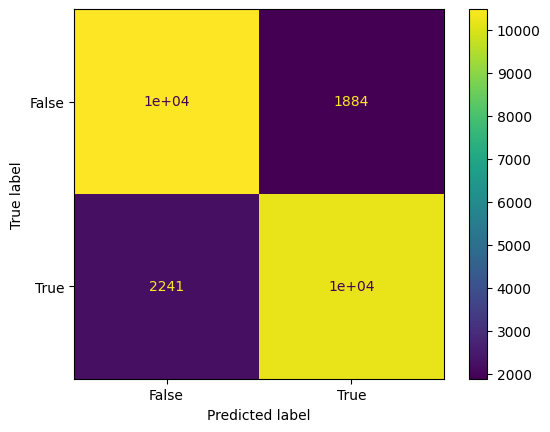

In [ ]:
cm = confusion_matrix(y_test, y_pred_randomForest)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = [False, True])
disp.plot()
plt.show()

###SVM

In [ ]:
#SVM
print(classification_report(y_test, y_pred_clf))

              precision    recall  f1-score   support

    negative       0.88      0.89      0.88     12361
    positive       0.89      0.88      0.88     12440

    accuracy                           0.88     24801
   macro avg       0.88      0.88      0.88     24801
weighted avg       0.88      0.88      0.88     24801



In [ ]:
#SVM best params
clf_pred_best_params = svm.SVC(
     C = 10, gamma = "scale"
    ).fit(X_train, y_train).predict(X_test)
print(classification_report(y_test, clf_pred_best_params))

              precision    recall  f1-score   support

    negative       0.87      0.89      0.88     12361
    positive       0.89      0.87      0.88     12440

    accuracy                           0.88     24801
   macro avg       0.88      0.88      0.88     24801
weighted avg       0.88      0.88      0.88     24801



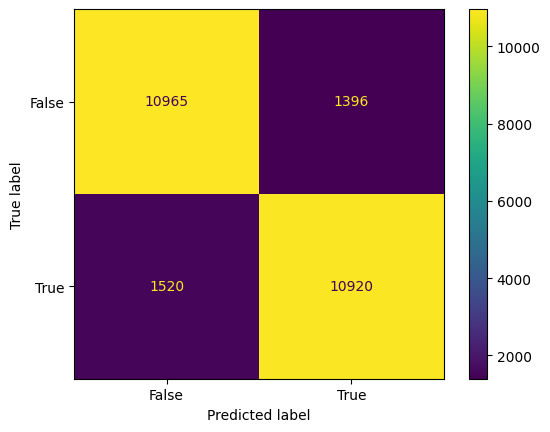

In [ ]:
cm = confusion_matrix(y_test, y_pred_clf)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = [False, True])
disp.plot()
plt.show()

###Naive Bayes

In [ ]:
#NB
print(classification_report(y_test, y_pred_nb))

              precision    recall  f1-score   support

    negative       0.79      0.88      0.83     12361
    positive       0.87      0.76      0.81     12440

    accuracy                           0.82     24801
   macro avg       0.83      0.82      0.82     24801
weighted avg       0.83      0.82      0.82     24801



In [ ]:
#NB best params
nb_pred_best_params = MultinomialNB(
      alpha= 1, fit_prior= True, force_alpha= False
    ).fit(X_train, y_train).predict(X_test)

print(classification_report(y_test, nb_pred_best_params))

              precision    recall  f1-score   support

    negative       0.79      0.88      0.83     12361
    positive       0.87      0.76      0.81     12440

    accuracy                           0.82     24801
   macro avg       0.83      0.82      0.82     24801
weighted avg       0.83      0.82      0.82     24801



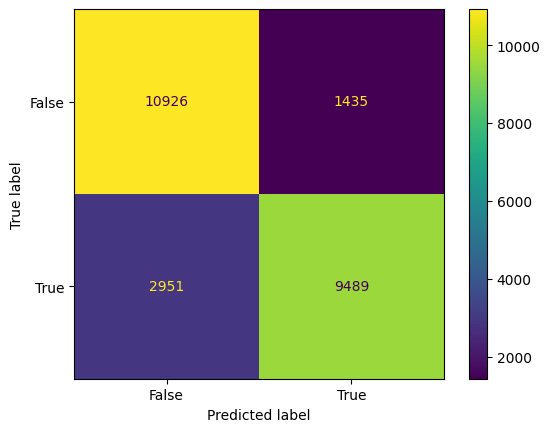

In [ ]:
cm = confusion_matrix(y_test, y_pred_nb)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = [False, True])
disp.plot()
plt.show()